In [1]:
## PREPROCESSING THE DATASET

In [1]:
# Import libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load all csv files of GoEmotions
pt1 = pd.read_csv("goemotions_1.csv")
pt2 = pd.read_csv("goemotions_2.csv")
pt3 = pd.read_csv("goemotions_3.csv")

# Combine the three parts into a single df
df = pd.concat([pt1, pt2, pt3], ignore_index=True)

# Define the emotion columns in binary labes
emotion_columns = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

# Assign a primary emotion to each entry
def get_primary_emotion(row):
    emotions = row[emotion_columns]
    emotion_list = emotions[emotions == 1].index.tolist()
    for emotion in emotion_columns:
        if emotion_list:
            return emotion_list[0]
        return 'neutral'

df['emotion'] = df.apply(get_primary_emotion, axis=1)

# Clean and preprocess text through NLTK
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase and tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)

# Preview outcome
df[['text', 'clean_text', 'emotion']].head(10)

,text,clean_text,emotion
0,That game hurt.,game hurt,sadness
1,>sexuality shouldn’t be a grouping category I...,sexuality shouldnt grouping category makes dif...,neutral
2,"You do right, if you don't care then fuck 'em!",right dont care fuck em,neutral
3,Man I love reddit.,man love reddit,love
4,"[NAME] was nowhere near them, he was by the Fa...",name nowhere near falcon,neutral
5,Right? Considering it’s such an important docu...,right considering important document know damn...,gratitude
6,"He isn't as big, but he's still quite popular....",isnt big hes still quite popular ive heard thi...,disapproval
7,That's crazy; I went to a super [RELIGION] hig...,thats crazy went super religion high school th...,amusement
8,that's adorable asf,thats adorable asf,amusement
9,"""Sponge Blurb Pubs Quaw Haha GURR ha AAa!"" fin...",sponge blurb pubs quaw haha gurr ha aaa finale...,amusement


In [ ]:
## EDA AND VISUALIZATIONS

In [5]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [49]:
# positive, negative, and ambiguous categorization was pulled from: https://www.kaggle.com/code/esknight/emotion-classification-final#Cleaning-Dataset
positive = {'admiration','amusement','approval','caring','desire','excitement','gratitude','joy','love','optimism','pride','relief'}
negative = {'sadness','fear','embarrassment','disapproval','disappointment','annoyance','anger','nervousness','remorse','grief','disgust'}
ambiguous = {'realization','surprise','curiosity','confusion','neutral'}

print(f'Fine grained emotions: {len(emotion_columns)}')
print(f'Number of positive emotions: {len(positive)}') 
print(f'Number of negative emotions: {len(negative)}')
print(f'Number of ambiguous emotions: {len(ambiguous)}')

Fine grained emotions: 28
Number of positive emotions: 12
Number of negative emotions: 11
Number of ambiguous emotions: 5


/var/folders/l0/m0tc25kj1qs4ld95zmgs81lm0000gn/T/ipykernel_16430/3512627530.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='emotion', y='count', data=emotion_counts, palette=emotion_counts['color'].tolist())


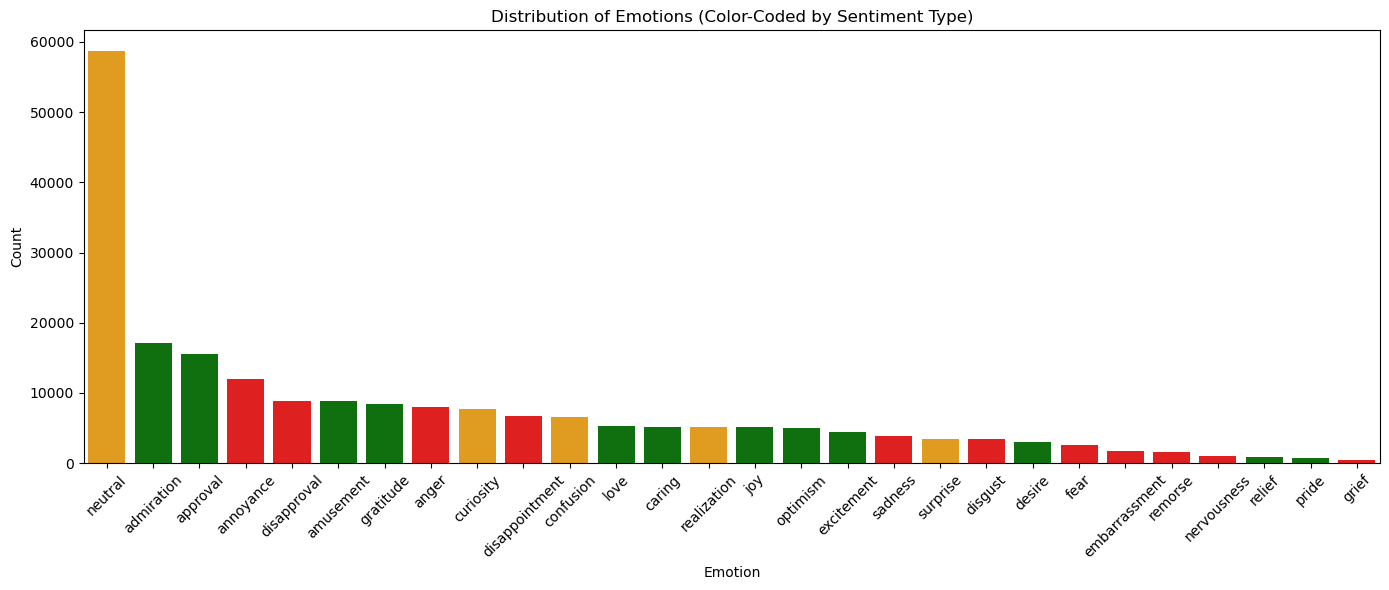

In [85]:
# Emotion Label Analysis - Bar Chart

# Group and count emotion frequencies
emotion_counts = df['emotion'].value_counts().reset_index()
emotion_counts.columns = ['emotion', 'count']

# Assign colors based on sentiment
def get_color(emotion):
    if emotion in positive:
        return 'green'
    elif emotion in negative:
        return 'red'
    elif emotion in ambiguous:
        return 'orange'
    else:
        return 'gray'

emotion_counts['color'] = emotion_counts['emotion'].apply(get_color)

# Sort by emotion count
emotion_counts = emotion_counts.sort_values(by='count', ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x='emotion', y='count', data=emotion_counts, palette=emotion_counts['color'].tolist())
plt.title("Distribution of Emotions (Color-Coded by Sentiment Type)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

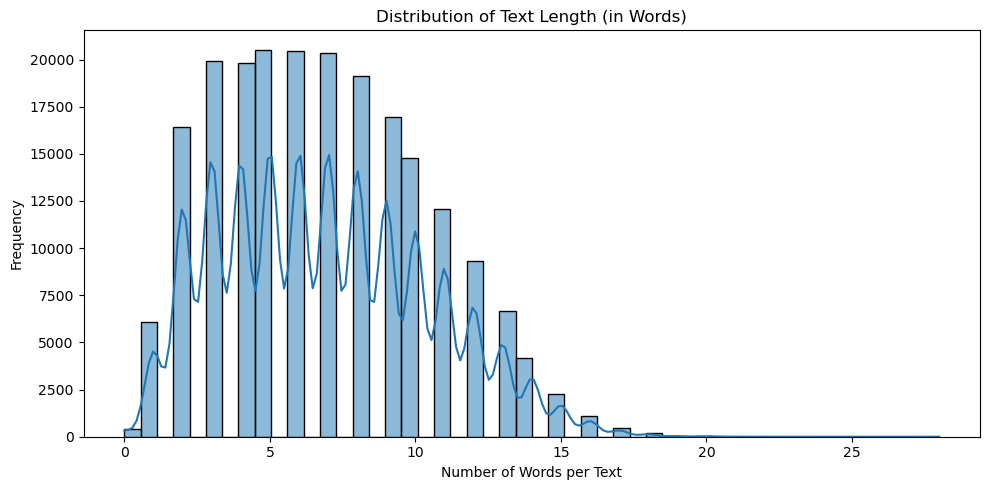

In [91]:
# Text Length Analysis - Histogram 
# Add a text length column
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Distribution of Text Length (in Words)")
plt.xlabel("Number of Words per Text")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

/var/folders/l0/m0tc25kj1qs4ld95zmgs81lm0000gn/T/ipykernel_16430/2001317430.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=(freqs), palette='mako')


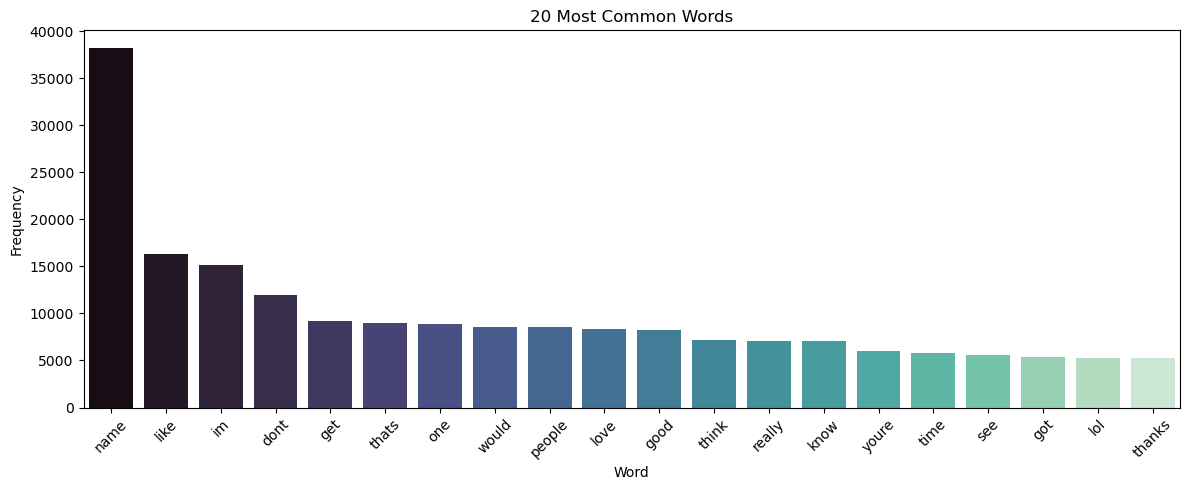

In [13]:
# Word Frequency Analysis - Bar Chart
# Combine clean_text into a list of words
all_words = ' '.join(df['clean_text']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

# Unzip word to freq pairs
words, freqs = zip(*common_words)

plt.figure(figsize=(12, 5))
sns.barplot(x=list(words), y=(freqs), palette='mako')
plt.title("20 Most Common Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

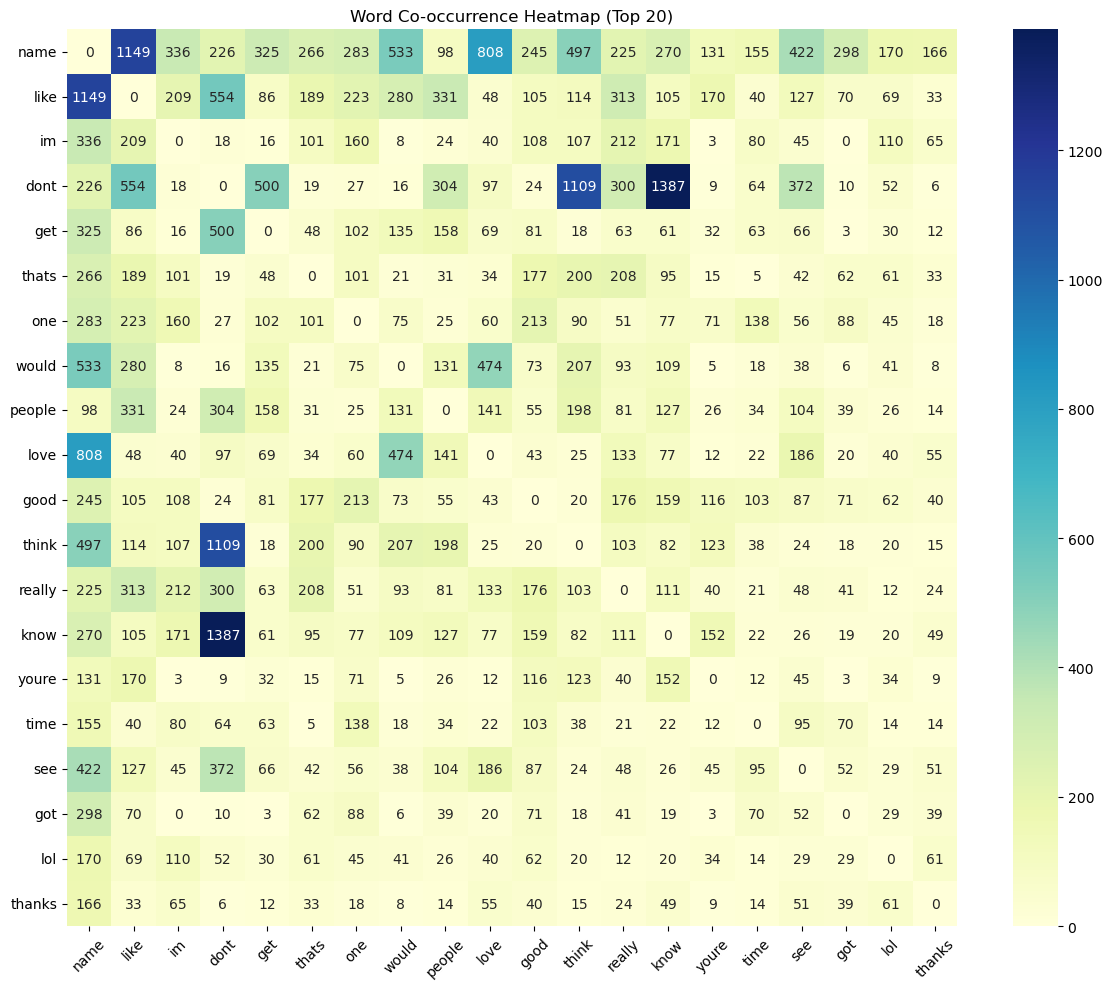

In [39]:
# Co-occurrance Analysis - Heatmap
import itertools
from collections import defaultdict

df['tokens'] = df['clean_text'].apply(lambda x: x.split())
window_size = 2
co_occurrence_counts = defaultdict(int)

# Count word co-occurrences
for tokens in df['tokens']:
    for i in range(len(tokens) - window_size + 1):
        window = tokens[i:i + window_size]
        for w1, w2 in itertools.combinations(set(window), 2):
            if w1 != w2:
                pair = tuple(sorted((w1, w2)))
                co_occurrence_counts[pair] += 1

# Create df for the c.o. counts
co_occur_df = pd.DataFrame(co_occurrence_counts.items(), columns = ['pair', 'count'])
co_occur_df = co_occur_df.sort_values(by='count', ascending=False).reset_index(drop=True)

# Get top N frequent words
freq_words = [word for word, _ in Counter(itertools.chain(*df['tokens'].tolist())).most_common(20)]
matrix = pd.DataFrame(index=freq_words, columns=freq_words, data = 0)

for (w1, w2), count in co_occurrence_counts.items():
    if w1 in freq_words and w2 in freq_words:
        matrix.loc[w1, w2] = count
        matrix.loc[w2, w1] = count

plt.figure(figsize= (12, 10))
sns.heatmap(matrix.astype(int), cmap='YlGnBu', annot=True, fmt='d')
plt.title("Word Co-occurrence Heatmap (Top 20)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
